In [3]:
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, silhouette_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sentence_transformers import SentenceTransformer

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import matplotlib.pyplot as plt

from joblib import dump

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_csv("../data/processed/train_profiles.csv")
df.head()

,age,location,ethnicity,occupation,status,description,scam,age_group,country
0,62,"14440 Villanueva de C??rdoba, C??rdoba, Espa??a",white,technology,separated,"I'm going by right,639 I am a very good friend...",0,61-70,Spain
1,33,"Frankfurt, Germany",white,carer,single,"Am loving,caring,honest,passionate,faithful an...",1,31-40,Germany
2,51,"Piscataway, New Jersey, or New York, United St...",other,engineering,divorced,I?€?m ready to explore the next chapter in my ...,1,51-60,United States
3,41,"Tijuana, B.C., M??xico",hispanic,other,single,"40 good vibes, very attentive, respectful, a l...",0,41-50,Mexico
4,42,"Guayaquil, Ecuador",hispanic,technology,single,"I am a normal, happy, fun person. I don't drin...",0,41-50,Ecuador


In [5]:
y = df['scam']
X = df.drop(columns=['scam','age','location'])
X

,ethnicity,occupation,status,description,age_group,country
0,white,technology,separated,"I'm going by right,639 I am a very good friend...",61-70,Spain
1,white,carer,single,"Am loving,caring,honest,passionate,faithful an...",31-40,Germany
2,other,engineering,divorced,I?€?m ready to explore the next chapter in my ...,51-60,United States
3,hispanic,other,single,"40 good vibes, very attentive, respectful, a l...",41-50,Mexico
4,hispanic,technology,single,"I am a normal, happy, fun person. I don't drin...",41-50,Ecuador
...,...,...,...,...,...,...
4770,white,other,divorced,well im a cool person who travels a lot i love...,51-60,United States
4771,hispanic,other,single,"I like them older, I want to have a good time.",21-30,United States
4772,white,other,divorced,I am a good humored single father hard working...,41-50,United States
4773,white,sales,divorced,"Hello, I am dual citizen living in New York an...",51-60,United States


# Predict with categorical features only

In [6]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [8]:
report = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1', 'auc','false positive rate','false negative rate'])
for i, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # encode remaining variables with one-hot encoding
    encoder = OneHotEncoder(handle_unknown="ignore")
    X_train_ohe = encoder.fit_transform(X_train.drop(["description"], axis=1))
    X_val_ohe = encoder.transform(X_val.drop(["description"], axis=1))
    
    # fit a logistic regression model to the data
    LR = LogisticRegression(max_iter=1000)
    LR.fit(X_train_ohe, y_train)

    # make a prediction
    y_pred = LR.predict(X_val_ohe)
    y_pred_proba = LR.predict_proba(X_val_ohe)[:, 1]
    cm = confusion_matrix(y_val, y_pred)
    
    # Extract TN, FP, FN, TP from confusion matrix
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate metrics for the current fold
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    # Calculate false positive rate and false negative rate
    total_samples = len(X_val)  # Total number of samples in current fold
    false_positive_rate = fp / total_samples  # False positive rate
    false_negative_rate = fn / total_samples  # False negative rate

    # add the results to the report
    report.loc[i] = [accuracy_score(y_val, y_pred),
                     precision_score(y_val, y_pred),
                     recall_score(y_val, y_pred),
                     f1_score(y_val, y_pred),
                     roc_auc_score(y_val, y_pred_proba),
                     false_positive_rate, 
                     false_negative_rate]
    
report.describe()

,accuracy,precision,recall,f1,auc,false positive rate,false negative rate
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.900732,0.878582,0.928680,0.902861,0.963234,0.063876,0.035391
std,0.011364,0.017395,0.010663,0.011866,0.007778,0.009708,0.004766
min,0.876310,0.844358,0.908696,0.880325,0.945777,0.048218,0.029350
25%,0.899371,0.871760,0.921841,0.900176,0.960308,0.059193,0.033473
50%,0.902720,0.877257,0.932028,0.904761,0.963931,0.063808,0.033543
75%,0.906759,0.889298,0.934694,0.907319,0.966948,0.067051,0.038260
max,0.918239,0.908730,0.944223,0.921529,0.975510,0.083857,0.043933


## Check feature importance

In [9]:
feature_importance = pd.DataFrame(zip(encoder.get_feature_names_out(), np.transpose(LR.coef_).flatten()), columns=['features', 'coef']) 
feature_importance.sort_values(by='coef', ascending=False)[:10]

,features,coef
59,status_widowed,3.311875
40,occupation_military,3.028107
61,age_group_21-30,2.408689
112,country_Ghana,2.316542
200,country_United states,2.221810
198,country_United Kingdom,1.725911
3,ethnicity_Native American,1.702394
199,country_United States,1.656198
30,occupation_engineering,1.586845
183,country_Switzerland,1.580306


In [10]:
feature_importance.sort_values(by='coef', ascending=True)[:10]

,features,coef
66,age_group_71-80,-3.112230
8,ethnicity_hispanic,-3.051794
90,country_Colombia,-2.860347
203,country_Venezuela,-2.492584
157,country_Peru,-2.342044
38,occupation_manufacturing,-2.314245
100,country_Ecuador,-2.252582
43,occupation_repair,-2.117568
44,occupation_retired,-2.101006
144,country_Mexico,-2.061451


In [11]:
stats = feature_importance["coef"].describe()
stats

count    209.000000
mean      -0.000049
std        1.030601
min       -3.112230
25%       -0.452028
50%        0.036508
75%        0.613847
max        3.311875
Name: coef, dtype: float64

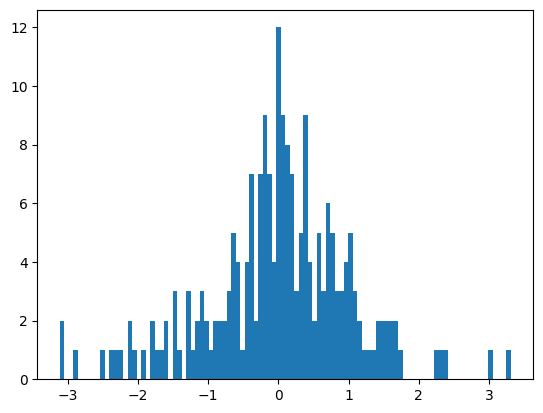

In [12]:
plt.hist(feature_importance["coef"], bins=100)
plt.show()

# Use descriptions to predict

In [13]:
stemmer = PorterStemmer()
 
def stem_words(text):
    # Split the input sentence into words
    word_tokens = text.split()
    # Stem each word individually
    stems = [stemmer.stem(word) for word in word_tokens]
    # Join the stemmed words back into a sentence
    stemmed_sentence = ' '.join(stems)
    return stemmed_sentence

def to_lower(value):
    # Process the value and return the result
    # For example, convert the value to lowercase
    return value.lower()

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    return ' '.join([word for word in words if word.lower() not in stop_words])


In [14]:
X['description']=X['description'].apply(to_lower)
X['description'] = X['description'].apply(remove_stopwords)
X['stem']=X['description'].apply(stem_words)

## BOW

In [20]:
report = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1', 'auc','false positive rate','false negative rate'])
for i, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    bow_vectorizer = CountVectorizer(max_features=1000)

    X_train_bow = bow_vectorizer.fit_transform(X_train["description"])
    X_val_bow = bow_vectorizer.transform(X_val["description"])

    # fit a logistic regression model to the data
    LR_bow = LogisticRegression()
    LR_bow.fit(X_train_bow, y_train)

    # make a prediction
    y_pred = LR_bow.predict(X_val_bow)
    y_pred_proba = LR_bow.predict_proba(X_val_bow)[:, 1]
    cm = confusion_matrix(y_val, y_pred)
    
    # Extract TN, FP, FN, TP from confusion matrix
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate metrics for the current fold
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    # Calculate false positive rate and false negative rate
    total_samples = len(X_val)  # Total number of samples in current fold
    false_positive_rate = fp / total_samples  # False positive rate
    false_negative_rate = fn / total_samples  # False negative rate

    # add the results to the report
    report.loc[i] = [accuracy_score(y_val, y_pred),
                     precision_score(y_val, y_pred),
                     recall_score(y_val, y_pred),
                     f1_score(y_val, y_pred),
                     roc_auc_score(y_val, y_pred_proba),
                     false_positive_rate, 
                     false_negative_rate]
    
report.describe()

,accuracy,precision,recall,f1,auc,false positive rate,false negative rate
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.852775,0.874918,0.822649,0.847284,0.922619,0.058630,0.088595
std,0.012200,0.026368,0.031703,0.014588,0.009536,0.013415,0.017888
min,0.826360,0.833333,0.765690,0.815145,0.905586,0.041929,0.058577
25%,0.845912,0.851748,0.807001,0.841499,0.918644,0.050236,0.076360
50%,0.853556,0.880480,0.821851,0.847222,0.924800,0.054448,0.092243
75%,0.863421,0.890725,0.839530,0.859977,0.929387,0.069591,0.098008
max,0.865828,0.909502,0.878261,0.862661,0.933664,0.079498,0.117155


In [21]:
report = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1', 'auc'])
for i, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    bow_vectorizer = CountVectorizer(stop_words=stopwords.words("english"), ngram_range=(1,3))

    X_train_bow = bow_vectorizer.fit_transform(X_train["description"])
    X_val_bow = bow_vectorizer.transform(X_val["description"])

    # fit a logistic regression model to the data
    LR_bow = LogisticRegression(max_iter=1000)
    LR_bow.fit(X_train_bow, y_train)

    # make a prediction
    y_pred = LR_bow.predict(X_val_bow)
    y_pred_proba = LR_bow.predict_proba(X_val_bow)[:, 1]

    # add the results to the report
    report.loc[i] = [accuracy_score(y_val, y_pred),
                     precision_score(y_val, y_pred),
                     recall_score(y_val, y_pred),
                     f1_score(y_val, y_pred),
                     roc_auc_score(y_val, y_pred_proba)]

report.describe()

,accuracy,precision,recall,f1,auc
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.861155,0.885394,0.828304,0.855524,0.932613
std,0.015420,0.028290,0.024067,0.018341,0.008846
min,0.841004,0.840708,0.786611,0.826484,0.917822
25%,0.851987,0.861198,0.809901,0.842495,0.927389
50%,0.857591,0.890430,0.839884,0.853623,0.931805
75%,0.873690,0.908074,0.844144,0.873145,0.934987
max,0.887029,0.920561,0.855856,0.879464,0.949641


In [22]:
feature_importance = pd.DataFrame(zip(bow_vectorizer.get_feature_names_out(), np.transpose(LR_bow.coef_).flatten()), columns=['features', 'coef']) 
feature_importance.sort_values(by='coef', ascending=False)[:10]

,features,coef
20617,com,2.937682
16621,caring,2.228260
24409,cool,1.794866
96149,name,1.711856
139048,tell,1.651552
127277,simple fun,1.497557
84475,lovely,1.477340
159011,yahoo,1.302606
87449,man,1.298761
137419,swimming,1.184834


In [23]:
feature_importance.sort_values(by='coef', ascending=True)[:10]

,features,coef
151218,wants,-1.042409
88211,man looking,-0.911962
95353,music,-0.904478
157198,worker,-0.898914
3202,affectionate,-0.819325
23016,consider,-0.796155
90201,mature,-0.783081
84613,lover,-0.772609
57989,hello,-0.744603
77261,likes,-0.731670


coefs represent the average change in the _log_ odds of the response variable associated with a one unit increase in the predictor variable. [see here](https://www.statology.org/interpret-logistic-regression-coefficients/)

In [24]:
stats = feature_importance["coef"].describe()
stats

count    160063.000000
mean          0.000675
std           0.052063
min          -1.042409
25%          -0.011197
50%           0.000058
75%           0.011137
max           2.937682
Name: coef, dtype: float64

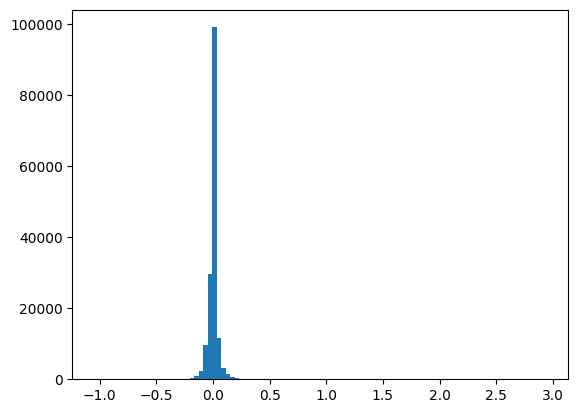

In [25]:
plt.hist(feature_importance["coef"], bins=100)
plt.show()

In [26]:
# get outliers using Tukey's method
iqr = stats["75%"] - stats["25%"]
k = 50 # typically k=1.5 or 3
outliers = feature_importance[(feature_importance["coef"] < stats["25%"] - iqr * k) | (feature_importance["coef"] > stats["75%"] + iqr * k)]
outliers

,features,coef
16621,caring,2.228260
20617,com,2.937682
24409,cool,1.794866
52632,good looking,1.151374
84475,lovely,1.477340
87449,man,1.298761
96149,name,1.711856
127277,simple fun,1.497557
137419,swimming,1.184834
139048,tell,1.651552


## Use TF-IDF

In [27]:
report = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1', 'auc'])
for i, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    tf_idf_vectorizer = TfidfVectorizer(stop_words=stopwords.words("english"), ngram_range=(1,3))

    X_train_tfidf = tf_idf_vectorizer.fit_transform(X_train["description"])
    X_val_tfidf = tf_idf_vectorizer.transform(X_val["description"])

    # fit a logistic regression model to the data
    LR_tfidf = LogisticRegression(max_iter=1000)
    LR_tfidf.fit(X_train_tfidf, y_train)

    # make a prediction
    y_pred = LR_tfidf.predict(X_val_tfidf)
    y_pred_proba = LR_tfidf.predict_proba(X_val_tfidf)[:, 1]

    # add the results to the report
    report.loc[i] = [accuracy_score(y_val, y_pred), 
                     precision_score(y_val, y_pred),
                     recall_score(y_val, y_pred),
                     f1_score(y_val, y_pred),
                     roc_auc_score(y_val, y_pred_proba)]

report.describe()

,accuracy,precision,recall,f1,auc
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.839383,0.785505,0.932195,0.852154,0.926390
std,0.022976,0.036533,0.012249,0.022855,0.011402
min,0.792887,0.711340,0.906122,0.807018,0.910350
25%,0.827841,0.762926,0.929761,0.838521,0.917925
50%,0.839623,0.792831,0.934058,0.856837,0.925950
75%,0.850418,0.807305,0.938794,0.860083,0.934948
max,0.874214,0.838710,0.951020,0.886364,0.941642


## Add BOW with categorical features

In [28]:
outliers

,features,coef
16621,caring,2.228260
20617,com,2.937682
24409,cool,1.794866
52632,good looking,1.151374
84475,lovely,1.477340
87449,man,1.298761
96149,name,1.711856
127277,simple fun,1.497557
137419,swimming,1.184834
139048,tell,1.651552


In [29]:
vocab = outliers["features"]

In [30]:
report = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1', 'auc'])
for i, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # encode categorical variables with one-hot encoding
    encoder = OneHotEncoder(handle_unknown="ignore")
    X_train_ohe = encoder.fit_transform(X_train.drop(["description"], axis=1))
    X_val_ohe = encoder.transform(X_val.drop(["description"], axis=1))
    
    bow_vectorizer = CountVectorizer(stop_words=stopwords.words("english"),
                                     ngram_range=(1,3),
                                     vocabulary=vocab)
    X_train_bow = bow_vectorizer.fit_transform(X_train["description"])
    X_val_bow = bow_vectorizer.transform(X_val["description"])

    X_train_combined = np.hstack([X_train_ohe.toarray(), X_train_bow.toarray()])
    X_val_combined = np.hstack([X_val_ohe.toarray(), X_val_bow.toarray()])

    # fit a logistic regression model to the data
    LR_combined = LogisticRegression(max_iter=1000)
    LR_combined.fit(X_train_combined, y_train)

    # make a prediction
    y_pred = LR_combined.predict(X_val_combined)
    y_pred_proba = LR_combined.predict_proba(X_val_combined)[:, 1]

    # add the results to the report
    report.loc[i] = [accuracy_score(y_val, y_pred),
                     precision_score(y_val, y_pred),
                     recall_score(y_val, y_pred),
                     f1_score(y_val, y_pred),
                     roc_auc_score(y_val, y_pred_proba)]

report.describe()

,accuracy,precision,recall,f1,auc
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.917277,0.905469,0.930955,0.917867,0.974805
std,0.012178,0.019464,0.017254,0.013098,0.007304
min,0.899582,0.874477,0.894068,0.898305,0.964423
25%,0.906336,0.897147,0.923527,0.905904,0.969401
50%,0.918239,0.906849,0.933874,0.920339,0.973210
75%,0.928239,0.917534,0.939115,0.928749,0.981191
max,0.933054,0.930894,0.959459,0.932790,0.985503


# Use sentence embeddings

In [31]:
sbert = SentenceTransformer("all-MiniLM-L6-v2")

KeyboardInterrupt: 

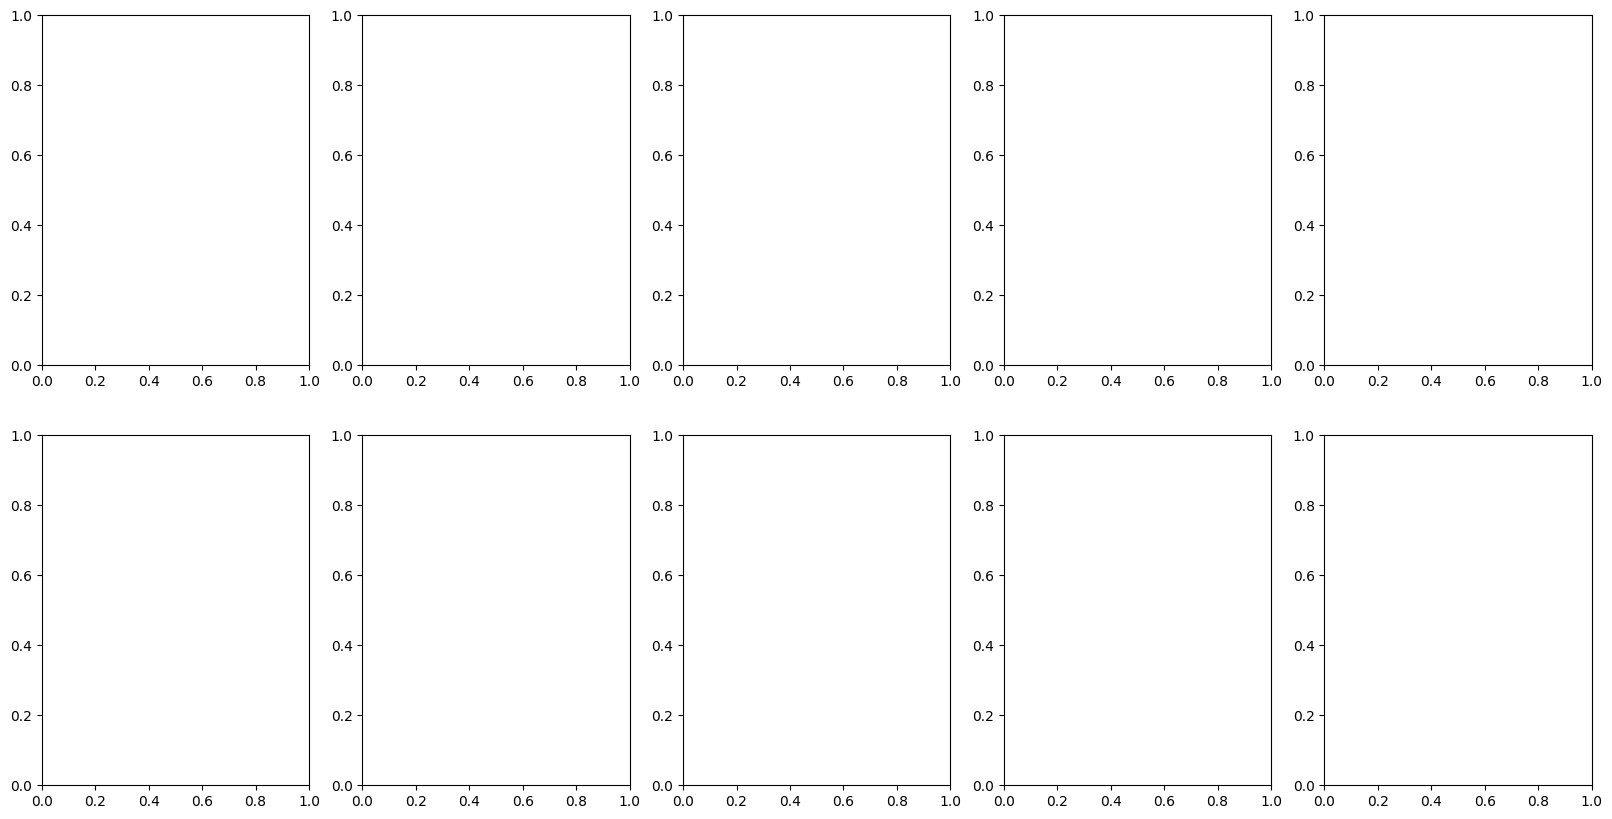

In [33]:
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    X_train_encoded = X_train["description"].apply(lambda x: sbert.encode(x))
    X_train_encoded = np.array(X_train_encoded.tolist())

    n_clusters = [2, 3, 4, 5, 10, 15, 20]
    parameter_grid = [{"n_clusters": i} for i in n_clusters]

    best_score = -1
    kmeans_model = KMeans(init="k-means++", n_init="auto", random_state=42)     # instantiating KMeans model
    silhouette_scores = []

    print("Fold", i+1)

    # evaluation based on silhouette_score
    for p in parameter_grid:
        kmeans_model.set_params(**p)    # set current hyper parameter
        kmeans_model.fit(X_train_encoded)          
        ss = silhouette_score(X_train_encoded, kmeans_model.labels_)   # calculate silhouette_score
        silhouette_scores += [ss]       # store all the scores
        
        # check p which has the best score
        if ss > best_score:
            best_score = ss
            optimal_n_clusters = p["n_clusters"]

    print("Optimal number of clusters:", optimal_n_clusters)
    print("Best silhouette score:", best_score)
    
    # plotting silhouette score
    axs[i//5, i%5].bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
    axs[i//5, i%5].set_xticks(range(len(silhouette_scores)), n_clusters)
    axs[i//5, i%5].set_xlabel('Number of Clusters')
    axs[i//5, i%5].set_ylabel('Silhouette Score')

plt.title("Silhouette Scores")
plt.show()

most values are near 0 which indicate overlapping clusters and not much separation

# Plot principal components

In [ ]:
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(X_train_encoded)
pca_2.explained_variance_ratio_

array([0.07327034, 0.05979143], dtype=float32)

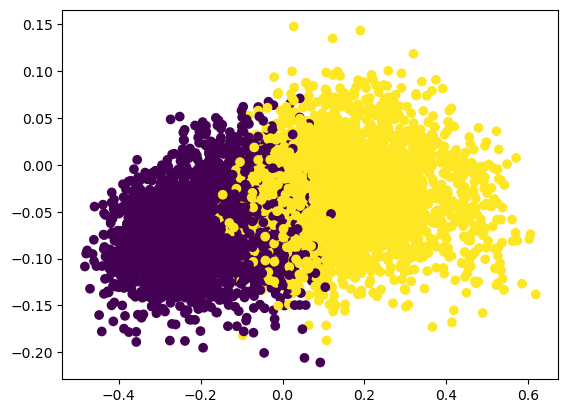

In [ ]:
# plot the clusters
plt.scatter(pca_2_result[:, 0], X_train_encoded[:, 1], c=kmeans.labels_, cmap='viridis')
plt.show()

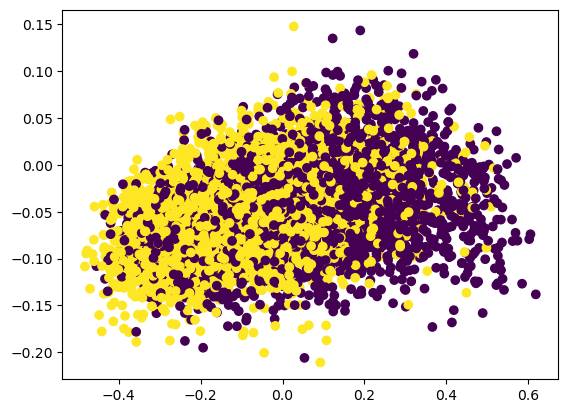

In [33]:
# plot the clusters with real labels
plt.scatter(pca_2_result[:, 0], X_train_encoded[:, 1], c=y_train, cmap='viridis')
plt.show()

## Add cluster label of sentence embedding of description as feature

In [54]:
report = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1'])
for i, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # encode remaining variables with one-hot encoding
    encoder = OneHotEncoder(handle_unknown="ignore")
    X_train_ohe = encoder.fit_transform(X_train.drop(["description"], axis=1))
    X_val_ohe = encoder.transform(X_val.drop(["description"], axis=1))

    X_train_encoded = np.array(X_train["description"].apply(lambda x: sbert.encode(x)).tolist())
    X_val_encoded = np.array(X_val["description"].apply(lambda x: sbert.encode(x)).tolist())

    kmeans_model = KMeans(n_clusters=2, init="k-means++", n_init="auto", random_state=42)
    kmeans_model.fit(X_train_encoded)

    X_train_clusters = kmeans_model.predict(X_train_encoded)
    X_val_clusters = kmeans_model.predict(X_val_encoded)

    X_train_combined = np.concatenate((X_train_ohe.toarray(), X_train_clusters.reshape(-1, 1)), axis=1)
    X_val_combined = np.concatenate((X_val_ohe.toarray(), X_val_clusters.reshape(-1, 1)), axis=1)
    
    # fit a logistic regression model to the data
    LR_combined = LogisticRegression(max_iter=1000)
    LR_combined.fit(X_train_combined, y_train)

    # make a prediction
    y_pred = LR_combined.predict(X_val_combined)

    # add the results to the report
    report.loc[i] = [accuracy_score(y_val, y_pred), precision_score(y_val, y_pred), recall_score(y_val, y_pred), f1_score(y_val, y_pred)]

report.describe()

X_train_ohe shape: (4297, 4435)
X_train_clusters shape: (4297,)
X_train_ohe shape: (4297, 4438)
X_train_clusters shape: (4297,)
X_train_ohe shape: (4297, 4435)
X_train_clusters shape: (4297,)
X_train_ohe shape: (4297, 4430)
X_train_clusters shape: (4297,)
X_train_ohe shape: (4297, 4433)
X_train_clusters shape: (4297,)
X_train_ohe shape: (4298, 4433)
X_train_clusters shape: (4298,)
X_train_ohe shape: (4298, 4430)
X_train_clusters shape: (4298,)
X_train_ohe shape: (4298, 4439)
X_train_clusters shape: (4298,)
X_train_ohe shape: (4298, 4433)
X_train_clusters shape: (4298,)
X_train_ohe shape: (4298, 4428)
X_train_clusters shape: (4298,)


,accuracy,precision,recall,f1
count,10.000000,10.000000,10.000000,10.000000
mean,0.906178,0.893915,0.920321,0.906871
std,0.013136,0.015529,0.016283,0.014028
min,0.882600,0.871901,0.894068,0.882845
25%,0.896967,0.881356,0.907345,0.898775
50%,0.908996,0.891244,0.922343,0.905129
75%,0.917759,0.908569,0.933440,0.919922
max,0.920335,0.915323,0.942857,0.924000


slight improvement in results

# Extra analysis

# Train model on entire training set

In [47]:
df = pd.read_csv("../data/processed/train_profiles.csv")

In [49]:
y = df['scam']
X = df.drop(columns=['scam','age','location'])

In [50]:
X

,ethnicity,occupation,status,description,age_group,country
0,white,technology,separated,"I'm going by right,639 I am a very good friend...",61-70,Spain
1,white,carer,single,"Am loving,caring,honest,passionate,faithful an...",31-40,Germany
2,other,engineering,divorced,I?€?m ready to explore the next chapter in my ...,51-60,United States
3,hispanic,other,single,"40 good vibes, very attentive, respectful, a l...",41-50,Mexico
4,hispanic,technology,single,"I am a normal, happy, fun person. I don't drin...",41-50,Ecuador
...,...,...,...,...,...,...
4770,white,other,divorced,well im a cool person who travels a lot i love...,51-60,United States
4771,hispanic,other,single,"I like them older, I want to have a good time.",21-30,United States
4772,white,other,divorced,I am a good humored single father hard working...,41-50,United States
4773,white,sales,divorced,"Hello, I am dual citizen living in New York an...",51-60,United States


In [51]:
# encode categorical variables with one-hot encoding
encoder = OneHotEncoder(handle_unknown="ignore")
X_train_ohe = encoder.fit_transform(X.drop(["description"], axis=1))

bow_vectorizer = CountVectorizer(stop_words=stopwords.words("english"),
                                    ngram_range=(1,3),
                                    vocabulary=vocab)
X_train_bow = bow_vectorizer.fit_transform(X["description"])

X_train_combined = np.hstack([X_train_ohe.toarray(), X_train_bow.toarray()])

# fit a logistic regression model to the data
LR_combined = LogisticRegression(max_iter=1000)
LR_combined.fit(X_train_combined, y)

LogisticRegression(max_iter=1000)

In [52]:
dump(encoder, '../src/saved_models/ohe_encoder.joblib')
dump(bow_vectorizer, '../src/saved_models/bow_vectorizer.joblib')
dump(LR_combined, '../src/saved_models/logistic_regression_trained.joblib') 

['../src/saved_models/logistic_regression_trained.joblib']